In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer
import geopandas as gpd
from shapely.geometry import Point

import os

In [ ]:
pd.set_option('display.max_rows', None)

sold01 = pd.read_csv('/content/CRMLSSold202412.csv')
sold02 = pd.read_csv('/content/CRMLSSold202501_filled.csv')
sold03 = pd.read_csv('/content/CRMLSSold202502.csv')
sold04 = pd.read_csv('/content/CRMLSSold202503.csv')
sold05 = pd.read_csv('/content/CRMLSSold202504.csv')
sold06 = pd.read_csv('/content/CRMLSSold202505.csv')

#Research Goal
To build a robust, user-focused machine learning model that accurately predicts the close price of any single-family residential property in California using only features available to consumers—enabling integration into a web application for real-time property value estimation.

## Data Requirment
1. Do not include **ListPrice** or any other features that would not be available for homes that are not currently for sale.

2. Drop the **Latfilled** and **Lonfilled** features

3. Include features that are available to the end user who is curious about the estimated close price.

4. Observation with **PropertyType** with Residential and **PropertySubType** with SingleFamilyResidence on constructing model



## 1.Data Processing

In [ ]:
print(sold01.shape)
print(sold02.shape)
print(sold03.shape)
print(sold04.shape)
print(sold05.shape)
print(sold06.shape)

(20241, 78)
(18738, 80)
(18702, 78)
(21445, 78)
(23262, 78)
(23154, 78)


In [ ]:
sold = [sold01, sold02, sold03, sold04, sold05, sold06]

for i in range(len(sold)):
  for j in range(len(sold)):
    if i != j:
      print(set(sold[i].columns)-set(sold[j].columns))




set()
set()
set()
set()
set()
{'latfilled', 'lonfilled'}
{'latfilled', 'lonfilled'}
{'latfilled', 'lonfilled'}
{'latfilled', 'lonfilled'}
{'latfilled', 'lonfilled'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


We can observe that other datasets have the same features, except the sold02 dataset is different with others involving the features of **lonfilled** and **latfilled**. Let's explore the columns for feature selection that aligns to our goal.

In [ ]:
sold01.head()

,BuyerAgentAOR,ListAgentAOR,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListingKey,ListAgentEmail,...,LotSizeDimensions,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict
0,Glendale,Glendale,NaN,NaN,NaN,NaN,NaN,3350000.0,552665323,Listings@LockerRealty.com,...,NaN,88445.0,NaN,False,0.0,NaN,91331,NaN,88445.0,NaN
1,InlandValleys,InlandValleys,NaN,True,NaN,NaN,NaN,125000.0,551977092,Patriciapandeyrealtor@gmail.com,...,NaN,9148.0,NaN,False,NaN,NaN,92530,0.0,9148.0,NaN
2,PacificWest,PacificWest,NaN,True,NaN,NaN,NaN,300000.0,551927931,joshuacho1004@gmail.com,...,NaN,6969600.0,NaN,False,NaN,NaN,92356,0.0,6969600.0,NaN
3,Mlslistings,Mlslistings,"Carpet,Laminate,Tile",False,NaN,NaN,NaN,800000.0,544420694,assistant@danmoskowitz.com,...,NaN,6418.0,NaN,False,0.0,Other,95122,NaN,6418.0,NaN
4,LakeCounty,LakeCounty,NaN,True,NaN,NaN,NaN,21500.0,516603298,jan@zapcom.net,...,NaN,4559.0,NaN,False,NaN,NaN,95464,0.0,4559.0,NaN


In [ ]:
sold01.columns

Index(['BuyerAgentAOR', 'ListAgentAOR', 'Flooring', 'ViewYN', 'WaterfrontYN',
       'BasementYN', 'PoolPrivateYN', 'OriginalListPrice', 'ListingKey',
       'ListAgentEmail', 'CloseDate', 'ClosePrice', 'ListAgentFirstName',
       'ListAgentLastName', 'Latitude', 'Longitude', 'UnparsedAddress',
       'PropertyType', 'LivingArea', 'ListPrice', 'DaysOnMarket',
       'ListOfficeName', 'BuyerOfficeName', 'CoListOfficeName',
       'ListAgentFullName', 'CoListAgentFirstName', 'CoListAgentLastName',
       'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName',
       'FireplacesTotal', 'AssociationFeeFrequency', 'AboveGradeFinishedArea',
       'ListingKeyNumeric', 'MLSAreaMajor', 'TaxAnnualAmount',
       'CountyOrParish', 'MlsStatus', 'ElementarySchool', 'AttachedGarageYN',
       'ParkingTotal', 'BuilderName', 'PropertySubType', 'LotSizeAcres',
       'SubdivisionName', 'BuyerOfficeAOR', 'YearBuilt', 'StreetNumberNumeric',
       'ListingId', 'BathroomsTotalInteger', 'City', '

1.**Features should involve**:

- **Property Space and Prices**: 'Living Area', 'StreetNumberNumeric', 'BathroomsTotalInteger', 'BuildingAreaTotal', 'BedroomsTotal', 'Stories', 'Levels', 'GarageSpaces', 'LotSizeSquareFeet','YearBuilt'

- **Location**: 'Latitude', 'Longitude', 'UnparsedAddress', 'CountyOrParish', 'City', 'StateOrProvince', 'PostalCode'

- **Facilities**: Flooring, ViewYN, WaterfrontYN, BasementYN, PoolPrivateYN, 'PropertyType' (Residential only), ‘PropertySubType’ (SingleFamilyResidence only), 'FireplacesTotal', 'AttachedGarageYN', 'ParkingTotal', 'BuilderName', 'CoveredSpaces', 'FireplaceYN', 'NewConstructionYN'

- **School**: 'ElementarySchool', 'ElementarySchoolDistrict', ,'MiddleOrJuniorSchool', 'HighSchool', 'HighSchoolDistrict', 'MiddleOrJuniorSchoolDistrict'




**Feature exclude**:  'latfilled', 'lonfilled', 'Listprice', 'BuyerAgentAOR', 'ListAgentAOR', 'OriginalListPrice', 'ListingKey', 'ListAgentEmail' 'DaysOnMarket', 'ListOfficeName', 'BuyerOfficeName', 'CoListAgentFirstName', 'CoListAgentLastName', 'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName', 'ListingKeyNumeric', 'MLSAreaMajor', 'MlsStatus', 'BuyerOfficeAOR', 'ListingId', 'ContractStatusChangeDate', 'CoBuyerAgentFirstName', 'PurchaseContractDate', 'ListingContractDate', 'BelowGradeFinishedArea', 'BusinessType', 'MainLevelBedrooms', 'LotSizeAcres', 'LotSizeDimensions', 'LotSizeArea'


**Considering features**: 'CloseDate', 'AssociationFeeFrequency', 'TaxAnnualAmount', 'BuilderName', 'SubdivisionName', 'TaxYear', 'AssociationFee',

In [ ]:
sold01.columns

Index(['BuyerAgentAOR', 'ListAgentAOR', 'Flooring', 'ViewYN', 'WaterfrontYN',
       'BasementYN', 'PoolPrivateYN', 'OriginalListPrice', 'ListingKey',
       'ListAgentEmail', 'CloseDate', 'ClosePrice', 'ListAgentFirstName',
       'ListAgentLastName', 'Latitude', 'Longitude', 'UnparsedAddress',
       'PropertyType', 'LivingArea', 'ListPrice', 'DaysOnMarket',
       'ListOfficeName', 'BuyerOfficeName', 'CoListOfficeName',
       'ListAgentFullName', 'CoListAgentFirstName', 'CoListAgentLastName',
       'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName',
       'FireplacesTotal', 'AssociationFeeFrequency', 'AboveGradeFinishedArea',
       'ListingKeyNumeric', 'MLSAreaMajor', 'TaxAnnualAmount',
       'CountyOrParish', 'MlsStatus', 'ElementarySchool', 'AttachedGarageYN',
       'ParkingTotal', 'BuilderName', 'PropertySubType', 'LotSizeAcres',
       'SubdivisionName', 'BuyerOfficeAOR', 'YearBuilt', 'StreetNumberNumeric',
       'ListingId', 'BathroomsTotalInteger', 'City', '

Let's exclude the features that not required for our research goal.

In [ ]:
sold01 = sold01[(sold01["PropertyType"]=='Residential')&(sold01["PropertySubType"]=='SingleFamilyResidence')].drop(['ListPrice', 'BuyerAgentAOR', 'ListAgentAOR', 'OriginalListPrice', 'ListingKey', 'ListAgentEmail', 'DaysOnMarket', 'ListOfficeName', 'BuyerOfficeName', 'CoListAgentFirstName', 'CoListAgentLastName', 'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName', 'ListingKeyNumeric', 'MLSAreaMajor', 'MlsStatus', 'BuyerOfficeAOR', 'ListingId', 'ContractStatusChangeDate', 'CoBuyerAgentFirstName', 'PurchaseContractDate', 'ListingContractDate', 'BelowGradeFinishedArea', 'BusinessType', 'MainLevelBedrooms', 'LotSizeAcres', 'LotSizeDimensions', 'LotSizeArea'],axis=1, errors='ignore')
sold02 = sold02[(sold02["PropertyType"]=='Residential')&(sold02["PropertySubType"]=='SingleFamilyResidence')].drop(['latfilled', 'lonfilled','ListPrice', 'BuyerAgentAOR', 'ListAgentAOR', 'OriginalListPrice', 'ListingKey', 'ListAgentEmail', 'DaysOnMarket', 'ListOfficeName', 'BuyerOfficeName', 'CoListAgentFirstName', 'CoListAgentLastName', 'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName', 'ListingKeyNumeric', 'MLSAreaMajor', 'MlsStatus', 'BuyerOfficeAOR', 'ListingId', 'ContractStatusChangeDate', 'CoBuyerAgentFirstName', 'PurchaseContractDate', 'ListingContractDate', 'BelowGradeFinishedArea', 'BusinessType', 'MainLevelBedrooms', 'LotSizeAcres', 'LotSizeDimensions', 'LotSizeArea'], axis=1, errors='ignore')
sold03 = sold03[(sold03["PropertyType"]=='Residential')&(sold03["PropertySubType"]=='SingleFamilyResidence')].drop(['ListPrice', 'BuyerAgentAOR', 'ListAgentAOR', 'OriginalListPrice', 'ListingKey', 'ListAgentEmail', 'DaysOnMarket', 'ListOfficeName', 'BuyerOfficeName', 'CoListAgentFirstName', 'CoListAgentLastName', 'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName', 'ListingKeyNumeric', 'MLSAreaMajor', 'MlsStatus', 'BuyerOfficeAOR', 'ListingId', 'ContractStatusChangeDate', 'CoBuyerAgentFirstName', 'PurchaseContractDate', 'ListingContractDate', 'BelowGradeFinishedArea', 'BusinessType', 'MainLevelBedrooms', 'LotSizeAcres', 'LotSizeDimensions', 'LotSizeArea'], axis=1, errors='ignore')
sold04 = sold04[(sold04["PropertyType"]=='Residential')&(sold04["PropertySubType"]=='SingleFamilyResidence')].drop(['ListPrice', 'BuyerAgentAOR', 'ListAgentAOR', 'OriginalListPrice', 'ListingKey', 'ListAgentEmail', 'DaysOnMarket', 'ListOfficeName', 'BuyerOfficeName', 'CoListAgentFirstName', 'CoListAgentLastName', 'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName', 'ListingKeyNumeric', 'MLSAreaMajor', 'MlsStatus', 'BuyerOfficeAOR', 'ListingId', 'ContractStatusChangeDate', 'CoBuyerAgentFirstName', 'PurchaseContractDate', 'ListingContractDate', 'BelowGradeFinishedArea', 'BusinessType', 'MainLevelBedrooms', 'LotSizeAcres', 'LotSizeDimensions', 'LotSizeArea'], axis=1, errors='ignore')
sold05 = sold05[(sold05["PropertyType"]=='Residential')&(sold05["PropertySubType"]=='SingleFamilyResidence')].drop(['ListPrice', 'BuyerAgentAOR', 'ListAgentAOR', 'OriginalListPrice', 'ListingKey', 'ListAgentEmail', 'DaysOnMarket', 'ListOfficeName', 'BuyerOfficeName', 'CoListAgentFirstName', 'CoListAgentLastName', 'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName', 'ListingKeyNumeric', 'MLSAreaMajor', 'MlsStatus', 'BuyerOfficeAOR', 'ListingId', 'ContractStatusChangeDate', 'CoBuyerAgentFirstName', 'PurchaseContractDate', 'ListingContractDate', 'BelowGradeFinishedArea', 'BusinessType', 'MainLevelBedrooms', 'LotSizeAcres', 'LotSizeDimensions', 'LotSizeArea'], axis=1, errors='ignore')
sold06 = sold06[(sold06["PropertyType"]=='Residential')&(sold06["PropertySubType"]=='SingleFamilyResidence')].drop(['ListPrice', 'BuyerAgentAOR', 'ListAgentAOR', 'OriginalListPrice', 'ListingKey', 'ListAgentEmail', 'DaysOnMarket', 'ListOfficeName', 'BuyerOfficeName', 'CoListAgentFirstName', 'CoListAgentLastName', 'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName', 'ListingKeyNumeric', 'MLSAreaMajor', 'MlsStatus', 'BuyerOfficeAOR', 'ListingId', 'ContractStatusChangeDate', 'CoBuyerAgentFirstName', 'PurchaseContractDate', 'ListingContractDate', 'BelowGradeFinishedArea', 'BusinessType', 'MainLevelBedrooms', 'LotSizeAcres', 'LotSizeDimensions', 'LotSizeArea'], axis=1, errors='ignore')


Let's combine the housing price datasets of past 3 to 6 months with considering duplicates of California properties.

In [ ]:
df= pd.concat([sold01, sold02, sold03, sold04, sold05, sold06], ignore_index=True)

row_df = df.shape[0]

print(df.shape)
df.head()
#show duplicated rows. If there is, we will drop it.
print(df[df.duplicated(keep=False)])

df = df.drop_duplicates()

row_df2 = df.shape[0]

print(df.shape)
df.head()

print(row_df - row_df2)


(61886, 49)
                        Flooring ViewYN WaterfrontYN BasementYN PoolPrivateYN  \
951                          NaN   True          NaN        NaN         False   
1527                         NaN   True          NaN        NaN         False   
8819                         NaN   True          NaN        NaN          True   
8824                         NaN   True          NaN        NaN          True   
41693                Carpet,Tile   True          NaN        NaN         False   
42783                Carpet,Tile   True          NaN        NaN         False   
46346                        NaN   True          NaN        NaN          True   
46889                        NaN   True          NaN        NaN          True   
50915  Carpet,Laminate,Tile,Wood  False          NaN        NaN           NaN   
50916  Carpet,Laminate,Tile,Wood  False          NaN        NaN           NaN   

        CloseDate  ClosePrice ListAgentFirstName ListAgentLastName   Latitude  \
951    2024-12-

We can see that there is some duplicate rows, and we droped 5 rows, not the property.

In [ ]:
df = df[df["StateOrProvince"]=="CA"]

row_df3 = df.shape[0]

print(df.shape)
print(row_df2-row_df3)

(61876, 49)
5


We only want to identify the California area housing price, and we can see that we drop 5 rows more that are not in California. (Total 5 rows dropped)

## 2. Data Cleaning

Let's dive into location features cleaning missing values and extreme outliers.

- **Location**: 'Latitude', 'Longitude', 'CountyOrParish', 'City', 'StateOrProvince', 'PostalCode'

In [ ]:
location = ['Latitude', 'Longitude','CountyOrParish', 'City', 'StateOrProvince', 'PostalCode']
print(df[location].isna().sum())

#check if there is implicit missing values for numerical features.
print(df[location].dtypes)


df[location].head()

Latitude            4
Longitude           4
CountyOrParish      0
City               56
StateOrProvince     0
PostalCode          0
dtype: int64
Latitude           float64
Longitude          float64
CountyOrParish      object
City                object
StateOrProvince     object
PostalCode          object
dtype: object


,Latitude,Longitude,CountyOrParish,City,StateOrProvince,PostalCode
0,37.330858,-121.849610,Santa Clara,San Jose,CA,95122
1,34.180411,-118.342020,Los Angeles,Burbank,CA,91505
2,32.574359,-117.023836,San Diego,San Diego,CA,92154
3,37.116859,-122.113773,Santa Cruz,Boulder Creek,CA,95006
4,33.725080,-117.222302,Riverside,Menifee,CA,92586


We can determine that there is couple missing values of 4 longitude and latitude, 64 addresses, and 56 cities.

In [ ]:
# Define placeholder values that represent implicit missing entries
placeholders = ["Unknown", "unknown", "N/A", "Not provided", "None", "--", ""]

# Show counts for placeholder values in City
print("City placeholder counts:")
print(df['City'].value_counts().loc[lambda x: x.index.isin(placeholders)])

City placeholder counts:
Series([], Name: count, dtype: int64)


In [ ]:
# Define placeholder values that represent implicit missing entries
placeholders = ["Unknown", "unknown", "N/A", "Not provided", "None", "--", ""]

# Show counts for placeholder values in City
print("CountyOrParish placeholder counts:")
print(df['CountyOrParish'].value_counts().loc[lambda x: x.index.isin(placeholders)])

CountyOrParish placeholder counts:
Series([], Name: count, dtype: int64)


In [ ]:
# Define placeholder values that represent implicit missing entries
placeholders = ["Unknown", "unknown", "N/A", "Not provided", "None", "--", ""]

# Show counts for placeholder values in City
print("PostalCode placeholder counts:")
print(df['PostalCode'].value_counts().loc[lambda x: x.index.isin(placeholders)])

PostalCode placeholder counts:
Series([], Name: count, dtype: int64)


The zipcode has no missing values and we can use that information to find missing values of longitude, latittude, city, and address.

Let's check if there is invalid zipcodes first before using the zipcodes.

In [ ]:
# make sure zipcode is string
df['PostalCode'] = df['PostalCode'].astype(str)

# Check for invalid postal codes that length should be 5 for U.S. postal codes
invalid_postal_codes = df[df['PostalCode'].str.len() != 5]
print(invalid_postal_codes)

# Print the number of rows with more than 5 characters in PostalCode
print("Number of rows with PostalCode longer than 5 digits:", invalid_postal_codes.shape[0])


df = df[df["PostalCode"].str.len()==5]


# Re-check for invalid postal codes if it excluded
invalid_postal_codes = df[df['PostalCode'].str.len() != 5]
print("Number of rows with PostalCode longer than 5 digits:", invalid_postal_codes.shape[0])



                              Flooring ViewYN WaterfrontYN BasementYN  \
11                       Laminate,Tile    NaN          NaN        NaN   
53                    Carpet,Tile,Wood   True          NaN        NaN   
468                             Carpet    NaN          NaN        NaN   
821                   Carpet,Tile,Wood    NaN          NaN        NaN   
1066                 Carpet,Vinyl,Wood    NaN          NaN        NaN   
1144     Carpet,Concrete,Laminate,Tile    NaN          NaN        NaN   
1231              Carpet,Laminate,Tile    NaN          NaN        NaN   
1455                               NaN    NaN          NaN        NaN   
1535                             Vinyl    NaN          NaN       True   
1597                  Carpet,Tile,Wood    NaN          NaN        NaN   
1848                            Carpet    NaN          NaN        NaN   
2069                       Carpet,Tile    NaN          NaN        NaN   
2207        Carpet,Laminate,Tile,Vinyl    NaN      

Cleaned zipcodes dropping invalid 5 digit zipcodes of 334 properties (Dropped total 339 properties.)

Now we can use the zipcodes aligned with missing longitude and latitude if it exists still.

In [ ]:
# check the missing values of longitude and latitude corresponding to zipcode
missing_longlat= df[(df['Latitude'].isna())|(df['Longitude'].isna())]

missing_longlat[["PostalCode", "City", "Latitude", "Longitude"]]

,PostalCode,City,Latitude,Longitude
17918,93923,Carmel,NaN,NaN
25894,95337,Manteca,NaN,NaN
32035,95337,Manteca,NaN,NaN
44034,95337,Manteca,NaN,NaN


We can see that longitude and latitude missing values are involved with same zipcodes. Let's fill missing values using zipcodes.

In [ ]:

geolocator = Nominatim(user_agent="monument")

geocoder = RateLimiter(geolocator.geocode, min_delay_seconds=1)

#call all zipcodes that have missing values of longitude and latitude
zipcodes_missing = df.loc[df['Latitude'].isna(), 'PostalCode'].unique()

lat={}
lon={}

for i in zipcodes_missing:
  location = geocoder(i)
  lat[i] = location.latitude
  lon[i] = location.longitude

# fill missing values what we found longitude and latitude
df['Latitude'] = df['Latitude'].fillna(df['PostalCode'].map(lat))
df['Longitude'] = df['Longitude'].fillna(df['PostalCode'].map(lon))

#check if the missing values have filled
print("latitude misssing values:", df['Latitude'].isna().sum())
print("longitude misssing values:", df['Longitude'].isna().sum())

#checking what is filled on missing values of longitude and latitude
missing_check=df.loc[missing_longlat.index, ["PostalCode", "City", "Latitude", "Longitude"]]

missing_check


latitude misssing values: 0
longitude misssing values: 0


,PostalCode,City,Latitude,Longitude
17918,93923,Carmel,36.555983,-120.679472
25894,95337,Manteca,37.785528,-121.231563
32035,95337,Manteca,37.785528,-121.231563
44034,95337,Manteca,37.785528,-121.231563


We filled missing values using geocoding finding the latitude and longitude corresponding to their zipcodes. We did not drop the rows here.

Let's check the missing values of cities and find those using geocoding.

In [ ]:
#Find zipcodes that cities are missing.
missing_cities=df[df['City'].isna()]

missing_cities[["PostalCode", "City"]]

,PostalCode,City
52,95672,NaN
196,92314,NaN
960,95002,NaN
1580,94065,NaN
1681,94933,NaN
5203,93933,NaN
6547,93933,NaN
7147,92679,NaN
7416,95628,NaN
7777,92277,NaN


In [ ]:
#List all the zipcodes that are missing cities
zipcodes_missing_city = df.loc[df['City'].isna(), 'PostalCode'].unique()

#fill all the missing cities into missing values
city={}

for i in zipcodes_missing_city:
  city[i] = location.address.split(',')[1]

df['City'] = df['City'].fillna(df['PostalCode'].map(city))

#check if it filled
print("City missing values:", df['City'].isna().sum())


#Check what missing values have filled of missing cities

missing_check_cities=df.loc[missing_cities.index, ["PostalCode", "City"]]

missing_check_cities

City missing values: 0


,PostalCode,City
52,95672,Manteca
196,92314,Manteca
960,95002,Manteca
1580,94065,Manteca
1681,94933,Manteca
5203,93933,Manteca
6547,93933,Manteca
7147,92679,Manteca
7416,95628,Manteca
7777,92277,Manteca


In [ ]:
location = ['Latitude', 'Longitude','CountyOrParish', 'City', 'StateOrProvince', 'PostalCode']
print(df[location].isna().sum())

Latitude           0
Longitude          0
CountyOrParish     0
City               0
StateOrProvince    0
PostalCode         0
dtype: int64


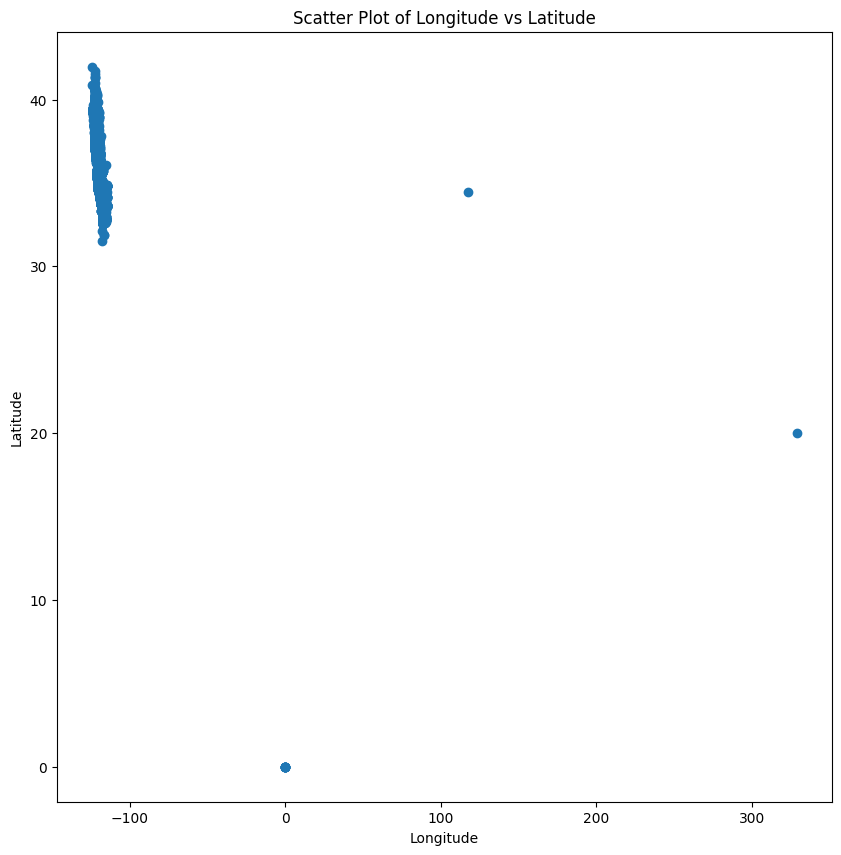

In [ ]:
#check the isolated area of California
plt.figure(figsize=(10, 10))
plt.scatter(df['Longitude'], df['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Longitude vs Latitude')
plt.show()

344


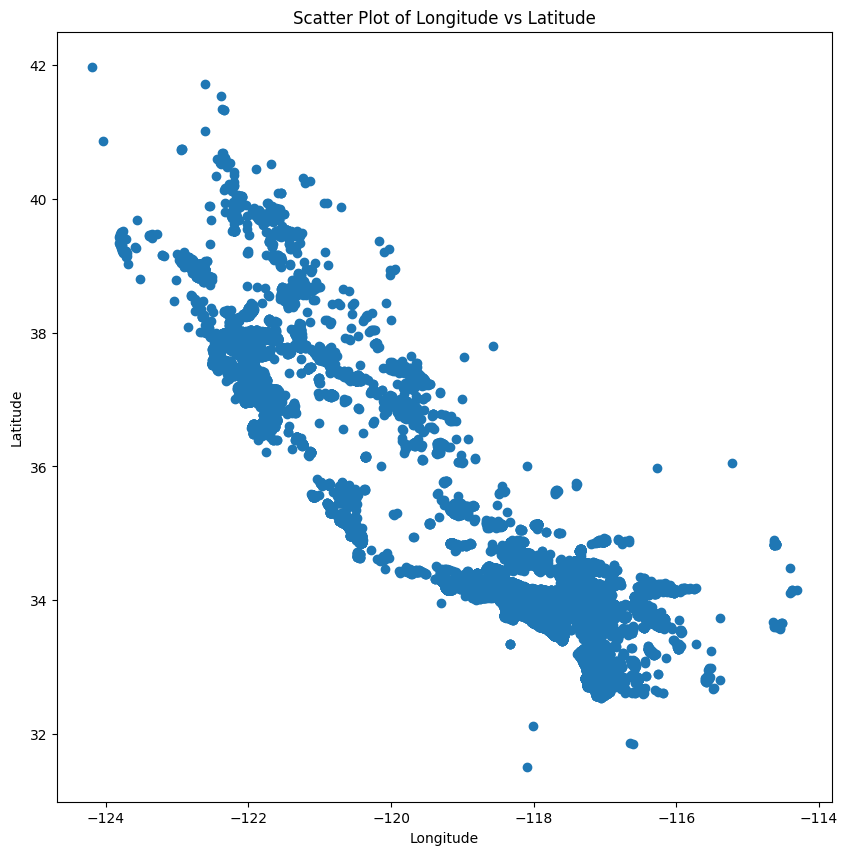

In [ ]:
#Drop the isloated area of California
df = df[(df['Latitude']>30)&(df['Longitude']<-50)]
row_df4 = df.shape[0]
print(row_df3-row_df4)

plt.figure(figsize=(10, 10))
plt.scatter(df['Longitude'], df['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Longitude vs Latitude')
plt.show()

We drop 10 properties that are isolated area in California.(Total 349 properties dropped)

Now, let's clean the cities and county values that there are so many distinct values influencing downside of predicting housing price. We will group it less than top 20 cities and county into "Others".

In [ ]:
city_count = df["City"].value_counts()
city_count

,count
City,
Los Angeles,2515
San Diego,2129
San Jose,1131
Riverside,942
Oakland,757
Menifee,694
Lancaster,609
Corona,588
Long Beach,577


There are too many unique value in school district that would potentionally lead overfitting and noise for machine learning performance. We will group it into **Top Tier District**, **Mid Tier District**, **Low Tier District**, and **Rare District** without including Unknown.

In [ ]:
#call all unique values without "Unknown"
count_city = df["City"].value_counts()
count_city

#Threshold for grouping the unique values
top = count_city.quantile(0.75)
mid= count_city.quantile(0.5)
low= count_city.quantile(0.25)

#Call out the grouping names including threshold into 4 different groups
def categorize_city(city):
  if city == "Unknown":
    return "Unknown"

  count = count_city[city]
  if count >= top:
    return "Top Tier city"
  elif count >= mid:
    return "Mid Tier city"
  elif count >= low:
    return "Low Tier city"
  else:
    return "Rare city"

#Apply the function
df["City"] = df["City"].apply(categorize_city)

#Check
df["City"].value_counts(normalize=True)

,proportion
City,
Top Tier city,0.810619
Mid Tier city,0.158860
Low Tier city,0.026100
Rare city,0.004420


In [ ]:
county_count = df["CountyOrParish"].value_counts()
county_count

,count
CountyOrParish,
Los Angeles,15226
Riverside,9789
San Diego,6762
San Bernardino,6639
Orange,5887
Alameda,2707
Contra Costa,2593
Santa Clara,2152
Ventura,1918


In [ ]:
#Group unpopular county less than 265 properties
other_counties= county_count[county_count<=100].index.tolist()
print(other_counties)

#name it "others" that are unpopular county
df['CountyOrParish'] = df['CountyOrParish'].replace(other_counties, 'Others')
df["CountyOrParish"].unique()

county_count = df["CountyOrParish"].value_counts()
county_count

['Mendocino', 'Glenn', 'Tehama', 'Tulare', 'Mariposa', 'Imperial', 'Kings', 'Yuba', 'Placer', 'Sonoma', 'Marin', 'Sutter', 'Napa', 'Shasta', 'Calaveras', 'Tuolumne', 'El Dorado', 'Yolo', 'Trinity', 'Plumas', 'Siskiyou', 'Nevada', 'Colusa', 'Amador', 'Mono', 'Humboldt', 'Del Norte', 'Inyo', 'Foreign Country', 'Other State']


,count
CountyOrParish,
Los Angeles,15226
Riverside,9789
San Diego,6762
San Bernardino,6639
Orange,5887
Alameda,2707
Contra Costa,2593
Santa Clara,2152
Ventura,1918


In [ ]:
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

# Macro Features - Tara
# including: Unemployment Rate, Inflation Rate, Interest Rate, CA Sales tax, Mortgage Rate 30 fixed
data_unemploy = pd.read_csv("/content/UNRATE (1).csv")
data_cpi = pd.read_csv("/content/CPIAUCNS (1).csv")
data_mortgage30us = pd.read_csv("/content/MORTGAGE30US (1).csv")
data_fedfunds = pd.read_csv("/content/FEDFUNDS (1).csv")
data_salestax = pd.read_csv("/content/SalesTaxRates (1).csv")

# CA Sales Tax
city_rate_map = data_salestax[data_salestax['Type'] == 'City'].set_index('Location')['Rate'].to_dict()
county_rate_map = data_salestax[data_salestax['Type'] == 'County'].set_index('County')['Rate'].to_dict()

def get_sales_tax_rate(row):
    city = row['City']
    county = row['CountyOrParish']
    # city match first
    if city in city_rate_map:
        return city_rate_map[city]
    # then county match
    elif county in county_rate_map:
        return county_rate_map[county]
    else:
        return 0.0725  # CA statewide tax rate
df['SalesTaxRate'] = df.apply(get_sales_tax_rate, axis=1)

df['CloseDate_Parsed'] = pd.to_datetime(df['CloseDate'], errors='coerce')
df['CloseDate_YearMonth'] = df['CloseDate_Parsed'].dt.strftime('%Y-%m')

# FedInterestRate
data_fedfunds['observation_date'] = pd.to_datetime(data_fedfunds['observation_date'])
data_fedfunds['CloseDate_YearMonth'] = data_fedfunds['observation_date'].dt.strftime('%Y-%m')
data_fedfunds = data_fedfunds.rename(columns={'FEDFUNDS': 'FedInterestRate'})

# Unemployment
data_unemploy['observation_date'] = pd.to_datetime(data_unemploy['observation_date'])
data_unemploy['CloseDate_YearMonth'] = data_unemploy['observation_date'].dt.strftime('%Y-%m')
data_unemploy = data_unemploy.rename(columns={'UNRATE': 'UnemploymentRate'})

# CPI
data_cpi['observation_date'] = pd.to_datetime(data_cpi['observation_date'])
data_cpi['CloseDate_YearMonth'] = data_cpi['observation_date'].dt.strftime('%Y-%m')
data_cpi = data_cpi.rename(columns={'CPIAUCNS': 'CPI'})

# Mortgage rate
data_mortgage30us['observation_date'] = pd.to_datetime(data_mortgage30us['observation_date'])
data_mortgage30us['CloseDate_YearMonth'] = data_mortgage30us['observation_date'].dt.strftime('%Y-%m')
data_mortgage30us = data_mortgage30us.rename(columns={'MORTGAGE30US': 'MortgageRate30Fixed'})

# Merge all macro data on CloseDate_YearMonth
df = df.merge(data_unemploy[['CloseDate_YearMonth', 'UnemploymentRate']], on='CloseDate_YearMonth', how='left')
df = df.merge(data_mortgage30us[['CloseDate_YearMonth', 'MortgageRate30Fixed']], on='CloseDate_YearMonth', how='left')
df = df.merge(data_fedfunds[['CloseDate_YearMonth', 'FedInterestRate']], on='CloseDate_YearMonth', how='left')
df = df.merge(data_cpi[['CloseDate_YearMonth', 'CPI']], on='CloseDate_YearMonth', how='left')
print(df[['CloseDate_YearMonth', 'UnemploymentRate', 'MortgageRate30Fixed', 'FedInterestRate', 'CPI']].drop_duplicates().sort_values('CloseDate_YearMonth'))

# Fill missing macro values with the median
macro_cols = ['UnemploymentRate', 'MortgageRate30Fixed', 'FedInterestRate', 'CPI']
for col in macro_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Remove outliers from ClosePrice
lower = df['ClosePrice'].quantile(0.01)
upper = df['ClosePrice'].quantile(0.99)
df = df[(df['ClosePrice'] >= lower) & (df['ClosePrice'] <= upper)]

# Remove outliers from property features - Tara
property_features = [
    'LivingArea', 'BathroomsTotalInteger','BedroomsTotal', 'Stories',
    'GarageSpaces', 'LotSizeSquareFeet'
]

for col in property_features:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df = df[(df[col] >= lower) & (df[col] <= upper)]

# Calculate House Age - Tommy
current_year = datetime.now().year
df['Age'] = current_year - df['YearBuilt']

# Feature Engineering lot density
df['LotDensity'] = df['LotSizeSquareFeet'] / df['LivingArea']
df['LotDensity'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values (Median imputation for missing values, since the data is right-skewed) - Tara
df['LivingArea'] = df['LivingArea'].fillna(df['LivingArea'].median())
df['Stories'] = df['Stories'].fillna(df['Stories'].median())
df['GarageSpaces'] = df['GarageSpaces'].fillna(df['GarageSpaces'].median())
df['LotSizeSquareFeet'] = df['LotSizeSquareFeet'].fillna(df['LotSizeSquareFeet'].median())
df['LotDensity'].fillna(df['LotDensity'].median(), inplace=True)

# Handle boolean facilities - Abhishek
facilities_features_bool = [
    'ViewYN','PoolPrivateYN', 'AttachedGarageYN',
    'ParkingTotal', 'FireplaceYN', 'NewConstructionYN'
]
# Hazel Note: filled with 0 instead of -1 as per discussed in the meeting
df[facilities_features_bool] = df[facilities_features_bool].fillna(0).astype(int)

# Flooring: one-hot encode multi-label values
df['Flooring'] = df['Flooring'].fillna('Unknown')
df['Flooring'] = df['Flooring'].str.split(',')
mlb = MultiLabelBinarizer()
flooring_dummies = pd.DataFrame(
    mlb.fit_transform(df['Flooring']),
    columns=['Flooring_' + f for f in mlb.classes_],
    index=df.index
)
df = pd.concat([df, flooring_dummies], axis=1)
df.drop(columns='Flooring', inplace=True)

# Create GeoDataFrame from coordinates - Hazel
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
homes_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load school districts shapefile (shp file needs shx and dbf files in the same directory)
districts_gdf = gpd.read_file('/content/tl_2023_06_unsd.shp')

# If the shapefile reports no CRS, assign the known native CRS (set, not transform)
if districts_gdf.crs is None:
    districts_gdf = districts_gdf.set_crs("EPSG:4269")  # TIGER/Line default

# Now you can safely transform to match your points (EPSG:4326)
districts_gdf = districts_gdf.to_crs(homes_gdf.crs)

# (Optional) heal invalid polygons before the join
districts_gdf['geometry'] = districts_gdf.buffer(0)

# Join and clean columns
homes_with_district = gpd.sjoin(homes_gdf, districts_gdf, how='left', predicate='within')

district_name_col = 'NAME'
district_id_col = 'GEOID'

extra_cols = set(homes_with_district.columns) - set(homes_gdf.columns) - {'index_right'}
to_drop = extra_cols - {district_name_col, district_id_col}
homes_with_district = homes_with_district.drop(columns=to_drop)

# Rename for clarity
homes_with_district = homes_with_district.rename(columns={
    district_name_col: 'SchoolDistrictName',
    district_id_col: 'SchoolDistrictID'
})

# One-hot encode school district name
homes_with_district['SchoolDistrictName'] = homes_with_district['SchoolDistrictName'].fillna('Unknown')
district_dummies = pd.get_dummies(homes_with_district['SchoolDistrictName'], prefix='District_')
df = pd.concat([homes_with_district.drop(columns=['SchoolDistrictName']), district_dummies], axis=1)

# Drop temporary columns created during processing
df = df.drop(columns=[
    'StreetNumberNumeric', 'YearBuilt', 'CloseDate', 'CloseDate_Parsed', 'CloseDate_YearMonth',
    'index_right', 'SchoolDistrictID', 'UnparsedAddress', 'StateOrProvince',
     'geometry',
    ])

# # Save to CSV
import google.colab.files as files

df.to_csv("cleaned_data_.csv", index=False)
files.download("cleaned_data_.csv")

      CloseDate_YearMonth  UnemploymentRate  MortgageRate30Fixed  \
0                 2024-12               4.1                 6.72   
10557             2025-01               4.0                 6.96   
18665             2025-02               4.1                 6.84   
27471             2025-03               4.2                 6.65   
38019             2025-04               4.2                 6.73   
49821             2025-05               4.2                 6.82   

       FedInterestRate      CPI  
0                 4.48  315.605  
10557             4.33  317.671  
18665             4.33  319.082  
27471             4.33  319.799  
38019             4.33  320.795  
49821             4.33  321.465  


/tmp/ipython-input-476021505.py:87: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LotDensity'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-476021505.py:94: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>